# Facial Recognition using FaceNet-PyTorch:
## Can my face be recognized?
---
Fascinated by the facial recognition technology, I tested the pretrained facial recognition model [FaceNet-PyTorch](https://github.com/timesler/facenet-pytorch), which was trained on the [VGGFace2](https://github.com/ox-vgg/vgg_face2) dataset with my photos. I started with the examples used in Neuromatch Academy Deep Learning online summer school 2021 (I was a teaching assistant there!), and then showed you how well the model could recognize my face.

Contents
- [Section 1: Setup](#Section-1:-Setup)
- [Section 2: Data processing](#Section-2:-Data-processing)
    - [Part 1: Download and prepare the data](#Part-1:-Download-and-prepare-the-data)
    - [Part 2: View and transform the data](#Part-2:-View-and-transform-the-data)
    - [Part 3: Embedding with a pretrained network](#Part-3:-Embedding-with-a-pretrained-network)
- [Section 3: Similarity and dissimilarity measures](#Section-3:-Similarity-and-dissimilarity-measures)
- [Section 4: Train a ResNet](#Section-4:-Train-a-ResNet)
    - [Part 1: Data selection](#Part-1:-Data-selection)
    - [Part 2: Fine-tuning a pretrained ResNet](#Part-2:-Fine-tuning-a-pretrained-ResNet)
    - [Part 3: Test with new images](#Part-3:-Test-with-new-images)
    - [Part 4: Train from scratch](#Part-4:-Train-from-scratch)

[comment]: <> (Section 5: Siamese Network)




# Facial Recognition using FaceNet-PyTorch:
## Can my face be recognized?
---
Fascinated by the facial recognition technology, I tested the pretrained facial recognition model [FaceNet-PyTorch](https://github.com/timesler/facenet-pytorch), which was trained on the [VGGFace2](https://github.com/ox-vgg/vgg_face2) dataset with my photos. I started with the examples used in Neuromatch Academy Deep Learning online summer school 2021 (I was a teaching assistant there!), and then showed you how well the model could recognize my face.

Contents
- [Section 1: Setup](#Section-1:-Setup)
- [Section 2: Data processing](#Section-2:-Data-processing)
    - [Part 1: Download and prepare the data](#Part-1:-Download-and-prepare-the-data)
    - [Part 2: View and transform the data](#Part-2:-View-and-transform-the-data)
    - [Part 3: Embedding with a pretrained network](#Part-3:-Embedding-with-a-pretrained-network)
- [Section 3: Similarity and dissimilarity measures](#Section-3:-Similarity-and-dissimilarity-measures)
- [Section 4: Train a ResNet](#Section-4:-Train-a-ResNet)
    - [Part 1: Data selection](#Part-1:-Data-selection)
    - [Part 2: Fine-tuning a pretrained ResNet](#Part-2:-Fine-tuning-a-pretrained-ResNet)
    - [Part 3: Test with new images](#Part-3:-Test-with-new-images)
    - [Part 4: Train from scratch](#Part-4:-Train-from-scratch)

[comment]: <> (Section 5: Siamese Network)




## Section 1: Setup

In [1]:
# Install dependencies
# Install `facenet` - a model used to do facial recognition

# pip install
# !pip install facenet-pytorch --quiet
# !pip install Pillow --quiet

# git clone (alternative installation in HPC) 
# !git clone https://github.com/timesler/facenet-pytorch.git facenet_pytorch
# !git clone https://aur.archlinux.org/python-pillow-git.git Pillow

In [2]:
# Import packages
import glob
import torch

import numpy as np
import sklearn.decomposition, sklearn.manifold
import matplotlib.pyplot as plt

from PIL import Image

from torchvision import transforms
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder

from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization

In [3]:
# Set random seed
# Executing `set_seed(seed=seed)` you are setting the seed
# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [4]:
# Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [5]:
SEED = 2021
set_seed(seed=SEED)
device = set_device()

Random seed 2021 has been set.


---
## Section 2: Data processing
### Part 1: Download and prepare the data

In [6]:
# Download Data
import requests, zipfile, io, os

# original link: https://github.com/ben-heil/cis_522_data.git
# url = 'https://osf.io/2kyfb/download'
fname = 'faces'
url = 'https://github.com/myyim/dataset/raw/main/'+fname+'.zip'

if not os.path.exists(fname+'zip'):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


### Part 2: View and transform the data

MTCNN ([github repo](https://github.com/ipazc/mtcnn)) detects the face and crops the image around the face.

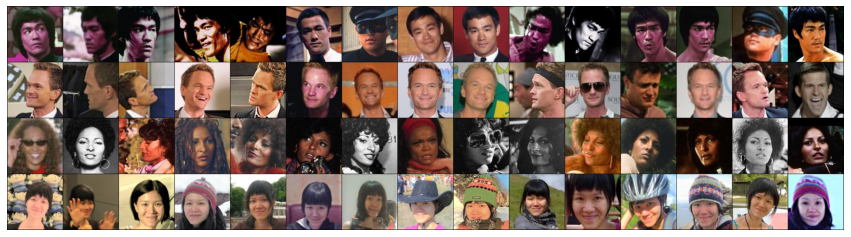

In [7]:
# Display Imaclass_to_idxges
# Here are the source images of Bruce Lee, Neil Patrick Harris, Pam Grier and me
train_transform = transforms.Compose((transforms.Resize((256, 256)),
                                      transforms.ToTensor()))

face_dataset = ImageFolder(fname, transform=train_transform)

face_loader = torch.utils.data.DataLoader(face_dataset,
                                          batch_size=60,
                                          shuffle=False)

dataiter = iter(face_loader)
images, labels = dataiter.next()

images_to_display = torch.cat((images[0:15,:,:,:],images[30:,:,:,:],images[15:30,:,:,:]))
# show images
plt.figure(figsize=(15, 15))
plt.imshow(make_grid(images_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [8]:
# Image Preprocessing Function
def process_images(image_dir: str, size=256):
  """
  This function returns two tensors for the given image dir: one usable for inputting into the
  facenet model, and one that is [0,1] scaled for visualizing

  Parameters:
    image_dir: The glob corresponding to images in a directory

  Returns:
    model_tensor: A image_count x channels x height x width tensor scaled to between -1 and 1,
                  with the faces detected and cropped to the center using mtcnn
    display_tensor: A transformed version of the model tensor scaled to between 0 and 1
  """
  mtcnn = MTCNN(image_size=size, margin=32)
  images = []
  for img_path in sorted(glob.glob(image_dir)):
    img = Image.open(img_path)
    # Cropimage
    img_cropped = mtcnn(img)
    images.append(img_cropped)

  model_tensor = torch.stack(images)
  display_tensor = model_tensor / (model_tensor.max() * 2)
  display_tensor += .5

  return model_tensor, display_tensor

/users/myim/.conda/envs/myenv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


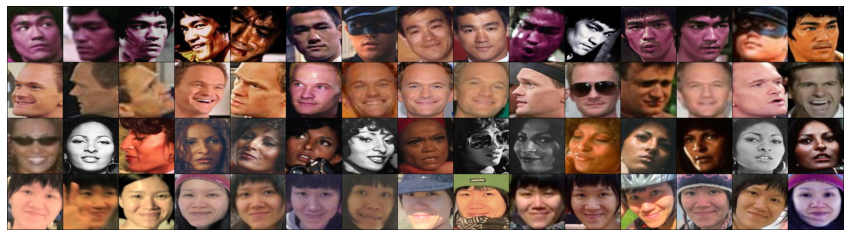

In [9]:
# Crop the images
bruce_tensor, bruce_display = process_images(fname+'/bruce/*.jpg')
neil_tensor, neil_display = process_images(fname+'/neil/*.jpg')
pam_tensor, pam_display = process_images(fname+'/pam/*.jpg')
manyi_tensor, manyi_display = process_images(fname+'/manyi/*.jpg')

tensor_to_display = torch.cat((bruce_display, neil_display, pam_display, manyi_display))

plt.figure(figsize=(15, 15))
plt.imshow(make_grid(tensor_to_display, nrow=15).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Part 3: Embedding with a pretrained network 

We use the pretrained facial recognition model called [FaceNet](https://github.com/timesler/facenet-pytorch) to calculate embeddings for all of our input images.

In [10]:
# Calculate embedding: 512-dimensional normalized vectors
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
resnet.classify = False
bruce_embeddings = resnet(bruce_tensor.to(device))
neil_embeddings = resnet(neil_tensor.to(device))
pam_embeddings = resnet(pam_tensor.to(device))
manyi_embeddings = resnet(manyi_tensor.to(device))

In [11]:
# Project the 512 dimensions onto a 2D space using Principal Component Analysis (PCA)
embedding_tensor = torch.cat((bruce_embeddings,
                              neil_embeddings,
                              pam_embeddings,
                              manyi_embeddings)).to(device='cpu')

pca = sklearn.decomposition.PCA(n_components=2)
pca_tensor = pca.fit_transform(embedding_tensor.detach().cpu().numpy())

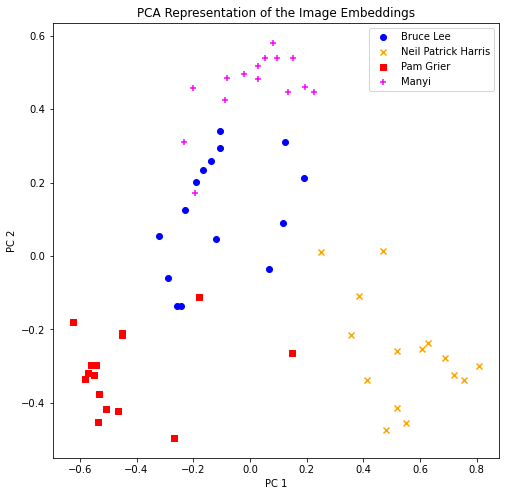

In [12]:
# PCA
num = 15
categs = 4
colors = ['blue', 'orange', 'red', 'magenta']
labels = ['Bruce Lee', 'Neil Patrick Harris', 'Pam Grier', 'Manyi']
markers = ['o', 'x', 's', '+']
plt.figure(figsize=(8, 8))
for i in range(categs):
   plt.scatter(pca_tensor[i*num:(i+1)*num, 0],
               pca_tensor[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=labels[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

---
## Section 3: Similarity and dissimilarity measures


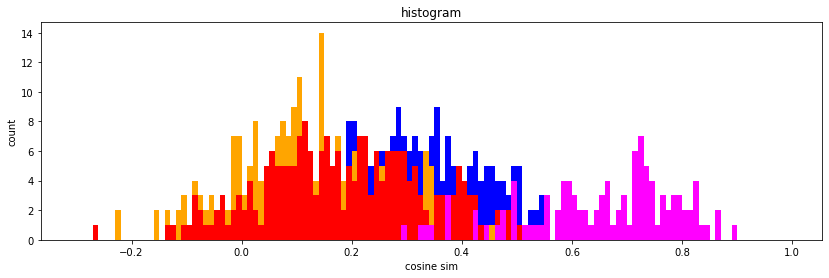

In [13]:
# Similarity using cosine or dot product
# (Since the embedding tensors are normalized, the two are equivalent)

sim_within = []
sim_across = [[],[],[]]
for j in range(15):
    for k in range(j+1,15):
        sim_within.append(np.dot(manyi_embeddings[j,:].detach().numpy(),manyi_embeddings[k,:].detach().numpy()))
        
for j in range(15):
    for k in range(15):
        sim_across[0].append(np.dot(manyi_embeddings[j,:].detach().numpy(),bruce_embeddings[k,:].detach().numpy()))
        sim_across[1].append(np.dot(manyi_embeddings[j,:].detach().numpy(),neil_embeddings[k,:].detach().numpy()))
        sim_across[2].append(np.dot(manyi_embeddings[j,:].detach().numpy(),pam_embeddings[k,:].detach().numpy()))
        
plt.figure(figsize=(14, 4))
for j in range(3):
    plt.hist(sim_across[j],np.arange(-0.3,1,0.01),color=colors[j])
plt.hist(sim_within,np.arange(-0.3,1,0.01),color=colors[3])
plt.title('histogram')
plt.xlabel('cosine sim')
plt.ylabel('count')
plt.show()    

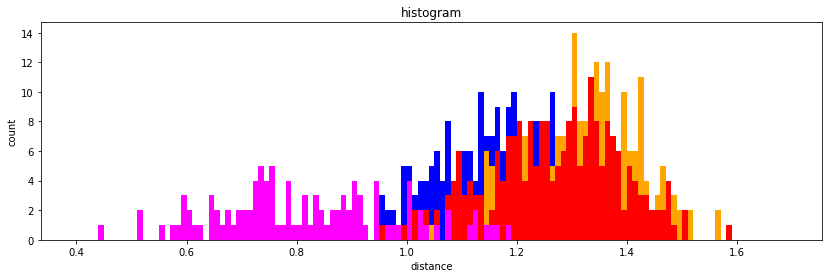

In [14]:
# Dissimilarity using Euclidean distance

dis_within = []
dis_across = [[],[],[]]
for j in range(15):
    for k in range(j+1,15):
        dis_within.append(np.linalg.norm((manyi_embeddings[j,:]-manyi_embeddings[k,:]).detach().numpy()))
        
for j in range(15):
    for k in range(15):
        dis_across[0].append(np.linalg.norm((manyi_embeddings[j,:]-bruce_embeddings[k,:]).detach().numpy()))
        dis_across[1].append(np.linalg.norm((manyi_embeddings[j,:]-neil_embeddings[k,:]).detach().numpy()))
        dis_across[2].append(np.linalg.norm((manyi_embeddings[j,:]-pam_embeddings[k,:]).detach().numpy()))
        
plt.figure(figsize=(14, 4))
for j in range(3):
    plt.hist(dis_across[j],np.arange(0.4,1.7,0.01),color=colors[j])
plt.hist(dis_within,np.arange(0.4,1.7,0.01),color=colors[3])
plt.title('histogram')
plt.xlabel('distance')
plt.ylabel('count')
plt.show()    

## Section 4: Train a ResNet
### Part 1: Data selection

In [15]:
# Download Data

fname = 'images'
url = 'https://github.com/myyim/dataset/raw/main/'+fname+'.zip'
num = 10
nppl = 5

if not os.path.exists(fname):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

Data is being downloaded...
The download has been completed.


In [16]:
# Crop and save the images
                
def save_cropped(dir_in,dir_out):
    for root, dirs, files in os.walk(dir_in):
        if root == dir_in:
            os.mkdir(dir_out)
            for dir in dirs:
                os.mkdir(dir_out+'/'+dir)
        else:
            _,img = process_images(root+'/*.jpg')
            dir = root.rsplit('/', 1)[-1]
            print('Images of ' + dir + ' are saved.')
            for j in range(img.shape[0]):
                save_image(img[j], './'+dir_out+'/'+dir+'/'+files[j])
                
save_cropped('images','girls')

/users/myim/.conda/envs/myenv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Images of coey are saved.
Images of kami are saved.
Images of karen are saved.
Images of manyi are saved.
Images of vicky are saved.


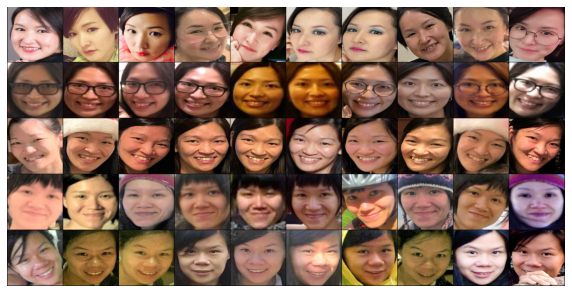

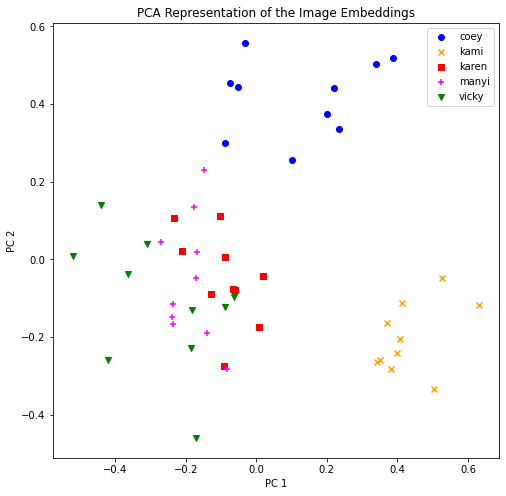

In [17]:
# Display the cropped images

fname = 'girls' # cropped

who = []
images_tensor = []
for root, dirs, _ in os.walk(fname):
    for dirname in sorted(dirs):
        who.append(dirname)
        image_tensor, image_display = process_images(fname + '/' + dirname + '/*.jpg')
        if images_tensor != []:
            images_tensor = torch.cat((images_tensor,image_tensor))
            images_display = torch.cat((images_display,image_display))
        else:
            images_tensor = image_tensor
            images_display = image_display

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(images_display,nrow=num).permute(1, 2, 0))
plt.axis('off')
plt.show()

# Calculate embedding: 512-dimensional normalized vectors
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
resnet.classify = False
embedding_tensor = resnet(images_tensor.to(device))


# t-SNE
# vector2d = sklearn.manifold.TSNE(n_components=2, learning_rate='auto',
#                    init='random').fit_transform(embedding_tensor.detach().cpu().numpy())

# PCA
pca = sklearn.decomposition.PCA(n_components=2)
vector2d = pca.fit_transform(embedding_tensor.detach().cpu().numpy())
colors = ['blue', 'orange', 'red', 'magenta','green']
markers = ['o', 'x', 's', '+', 'v']
plt.figure(figsize=(8, 8))
for i in range(nppl):
    plt.scatter(vector2d[i*num:(i+1)*num, 0],
                vector2d[i*num:(i+1)*num, 1],
                c=colors[i],marker=markers[i],label=who[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
# plt.title('t-SNE Representation of the Image Embeddings')
plt.show()

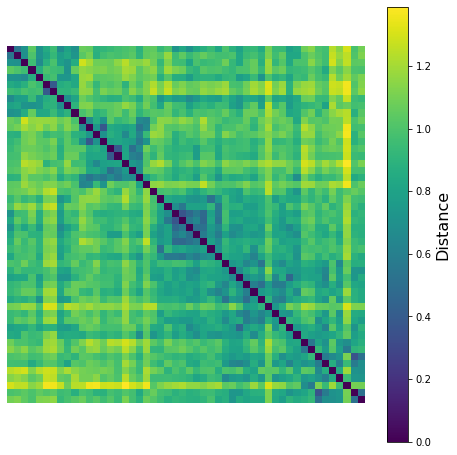

In [18]:
distances = torch.cdist(embedding_tensor, embedding_tensor)

plt.figure(figsize=(8, 8))
plt.imshow(distances.detach().cpu().numpy())
cbar = plt.colorbar()
cbar.set_label('Distance', fontsize=16)
plt.axis('off')
plt.show()

In [19]:
# Define train and test set

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

image_dataset = ImageFolder(fname, transform=trans)
# image_loader = torch.utils.data.DataLoader(image_dataset,
#                                           batch_size=nppl*num,
#                                           shuffle=False)

idx = torch.arange(nppl*num)
train_indices = idx[torch.remainder(idx,10)<=7]
test_indices = idx[torch.remainder(idx,10)>7]

image_train_set = torch.utils.data.Subset(image_dataset, train_indices)
image_test_set = torch.utils.data.Subset(image_dataset, test_indices)

image_train_loader = torch.utils.data.DataLoader(image_train_set,
                                                   batch_size=5,
                                                   shuffle=True,)
image_test_loader = torch.utils.data.DataLoader(image_test_set,
                                                  batch_size=5)

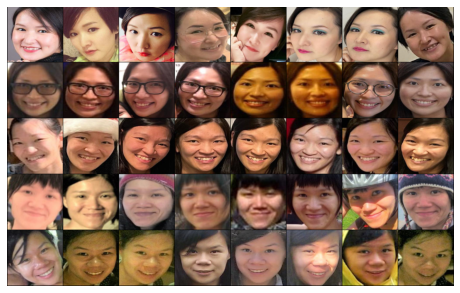

In [20]:
# Train set
train_set = torch.utils.data.Subset(image_dataset, train_indices)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=50,shuffle=False)

dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(8, 8))
plt.imshow(make_grid(images/2+0.5, nrow=8).permute(1, 2, 0))
plt.axis('off')
plt.show()

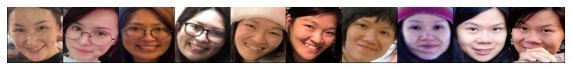

In [21]:
# Test set
test_set = torch.utils.data.Subset(image_dataset, test_indices)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=50,shuffle=False)

dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
plt.figure(figsize=(10, 10))
plt.imshow(make_grid(images/2+0.5, nrow=10).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Part 2: Fine-tuning a pretrained ResNet

In [22]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=nppl
).eval().to(device)

optimizer = torch.optim.Adam(resnet.parameters(), lr=0.00005)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

print('\n\nInitial')
print('-' * 10)
resnet.eval()
loss_val, metric_val = training.pass_epoch(
    resnet, loss_fn, image_test_loader,
    batch_metrics=metrics, show_running=True, device=device
)
lossfunc = [loss_val]
accfunc = [metric_val['acc']]

epochs = 10
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, image_train_loader, optimizer,
        batch_metrics=metrics, show_running=True, device=device
    )

    resnet.eval()
    loss_val, metric_val = training.pass_epoch(
        resnet, loss_fn, image_test_loader,
        batch_metrics=metrics, show_running=True, device=device
    )
    lossfunc.append(loss_val)
    accfunc.append(metric_val['acc'])
    
lossfunc = torch.stack(lossfunc)
accfunc = torch.stack(accfunc)



Initial
----------
Valid |     2/2    | loss:    1.6780 | fps:    8.4721 | acc:    0.3000   

Epoch 1/10
----------
Train |     8/8    | loss:    1.3465 | fps:    2.8874 | acc:    0.3500   
Valid |     2/2    | loss:    0.9507 | fps:    8.2251 | acc:    0.8000   

Epoch 2/10
----------
Train |     8/8    | loss:    0.5744 | fps:    2.9008 | acc:    0.9750   
Valid |     2/2    | loss:    0.6275 | fps:    8.3444 | acc:    0.9000   

Epoch 3/10
----------
Train |     8/8    | loss:    0.2710 | fps:    2.8781 | acc:    0.9750   
Valid |     2/2    | loss:    0.5264 | fps:    8.2294 | acc:    0.9000   

Epoch 4/10
----------
Train |     8/8    | loss:    0.2307 | fps:    2.8869 | acc:    1.0000   
Valid |     2/2    | loss:    0.3771 | fps:    8.2733 | acc:    1.0000   

Epoch 5/10
----------
Train |     8/8    | loss:    0.1761 | fps:    2.9046 | acc:    1.0000   
Valid |     2/2    | loss:    0.3042 | fps:    8.3142 | acc:    1.0000   

Epoch 6/10
----------
Train |     8/8    | loss: 

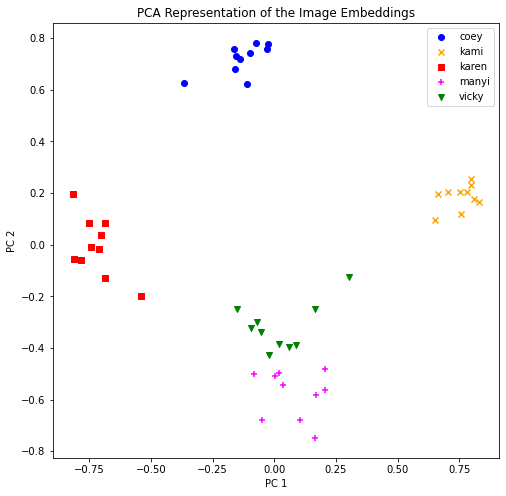

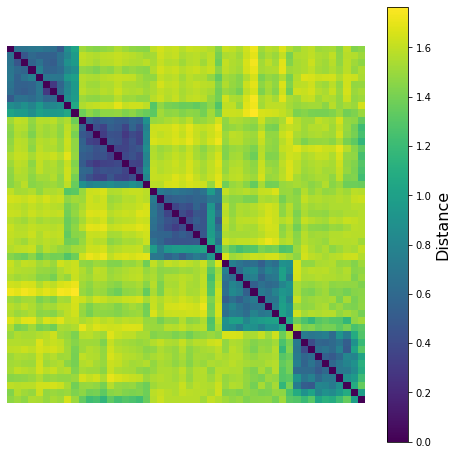

In [23]:
# embeddings after training
resnet.classify = False
embedding_tensor = resnet(images_tensor.to(device))

# PCA
pca = sklearn.decomposition.PCA(n_components=2)
vector2d = pca.fit_transform(embedding_tensor.detach().cpu().numpy())
colors = ['blue', 'orange', 'red', 'magenta','green']
markers = ['o', 'x', 's', '+', 'v']
plt.figure(figsize=(8, 8))
for i in range(nppl):
   plt.scatter(vector2d[i*num:(i+1)*num, 0],
               vector2d[i*num:(i+1)*num, 1],
               c=colors[i],
               marker=markers[i], label=who[i])
plt.legend()
plt.title('PCA Representation of the Image Embeddings')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

distances = torch.cdist(embedding_tensor, embedding_tensor)
plt.figure(figsize=(8, 8))
plt.imshow(distances.detach().cpu().numpy())
cbar = plt.colorbar()
cbar.set_label('Distance', fontsize=16)
plt.axis('off')
plt.show()

### Part 3: Test with new images

In [24]:
def sigmoid(s):
    return np.exp(s)/(1+np.exp(s))

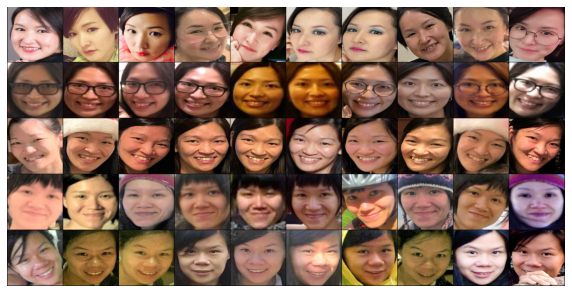

Prediction from the trained network (chance level = 20.0%)
1 coey (99.19182%)
2 coey (99.00974%)
3 coey (98.67054%)
4 coey (98.695045%)
5 coey (99.04654%)
6 coey (99.16093%)
7 coey (99.00918%)
8 coey (99.16619%)
9 coey (94.4926%)
10 coey (88.60233%)
11 kami (99.58566%)
12 kami (99.293526%)
13 kami (99.58353%)
14 kami (99.72233%)
15 kami (99.2239%)
16 kami (99.64138%)
17 kami (99.545906%)
18 kami (99.28566%)
19 kami (99.3023%)
20 kami (94.986305%)
21 karen (98.72651%)
22 karen (99.40956%)
23 karen (98.65308%)
24 karen (98.899445%)
25 karen (98.64778%)
26 karen (99.11444%)
27 karen (99.10573%)
28 karen (98.873695%)
29 karen (94.05113%)
30 karen (95.2901%)
31 manyi (99.305275%)
32 manyi (99.35101%)
33 manyi (99.24502%)
34 manyi (99.24829%)
35 manyi (98.91375%)
36 manyi (99.30211%)
37 manyi (99.069176%)
38 manyi (99.09244%)
39 manyi (92.79854%)
40 manyi (97.07104%)
41 vicky (98.74477%)
42 vicky (98.35755%)
43 vicky (98.70057%)
44 vicky (98.8602%)
45 vicky (98.866776%)
46 vicky (99.059875%)

In [25]:
# Verify with original images

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(images_display,nrow=num).permute(1, 2, 0))
plt.axis('off')
plt.show()

resnet.classify = True
logit = resnet(images_tensor.to(device))

print('Prediction from the trained network (chance level = '+str(100/nppl)+'%)')
val, ind = torch.max(logit,1)
prob = sigmoid(val.detach().numpy())*100
for j in range(50):
    print(str(j+1) + ' ' + who[ind[j]] + ' (' + str(prob[j]) + '%)')

Data is being downloaded...
The download has been completed.


/users/myim/.conda/envs/myenv/lib/python3.9/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


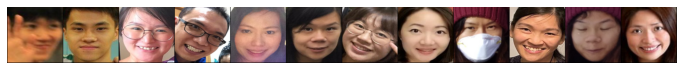

Prediction from the trained network (chance level = 20.0%)
1 manyi (96.82199%)
2 vicky (80.62342%)
3 coey (89.31911%)
4 kami (64.3095%)
5 vicky (88.304405%)
6 vicky (96.79001%)
7 kami (85.91605%)
8 coey (88.00963%)
9 manyi (81.53776%)
10 karen (97.54357%)
11 vicky (90.14229%)
12 kami (97.15864%)


In [26]:
import requests, zipfile, io, os

fname = 'testfaces'
url = 'https://github.com/myyim/dataset/raw/main/'+fname+'.zip'

if not os.path.exists(fname):
  print("Data is being downloaded...")
  r = requests.get(url, stream=True)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall()
  print("The download has been completed.")
else:
  print("Data has already been downloaded.")

num = 12
testfaces_tensor, testfaces_display = process_images(fname +'/*.jpg')
plt.figure(figsize=(12, 12))
plt.imshow(make_grid(testfaces_display,nrow=num).permute(1, 2, 0))
plt.axis('off')
plt.show()

resnet.classify = True
logit = resnet(testfaces_tensor.to(device))

print('Prediction from the trained network (chance level = '+str(100/nppl)+'%)')
val, ind = torch.max(logit,1)
prob = sigmoid(val.detach().numpy())*100
for j in range(num):
    print(str(j+1) + ' ' + who[ind[j]] + ' (' + str(prob[j]) + '%)')

### Part 4: Train from scratch

In [27]:
resnet2 = InceptionResnetV1(
    classify=True,
    pretrained=None,
    num_classes=nppl
)

optimizer = torch.optim.Adam(resnet2.parameters(), lr=0.00005)
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

print('\n\nInitial')
print('-' * 10)
resnet2.eval()
loss_val, metric_val = training.pass_epoch(
    resnet2, loss_fn, image_test_loader,
    batch_metrics=metrics, show_running=True, device=device
)
lossfunc2 = [loss_val]
accfunc2 = [metric_val['acc']]

epochs = 10
for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet2.train()
    training.pass_epoch(
        resnet2, loss_fn, image_train_loader, optimizer,
        batch_metrics=metrics, show_running=True, device=device
    )

    resnet2.eval()
    loss_val, metric_val = training.pass_epoch(
        resnet2, loss_fn, image_test_loader,
        batch_metrics=metrics, show_running=True, device=device,
    )
    lossfunc2.append(loss_val)
    accfunc2.append(metric_val['acc'])
    
lossfunc2 = torch.stack(lossfunc2)
accfunc2 = torch.stack(accfunc2)



Initial
----------
Valid |     2/2    | loss:    1.6097 | fps:    9.1238 | acc:    0.2000   

Epoch 1/10
----------
Train |     8/8    | loss:    1.7289 | fps:    2.9090 | acc:    0.2250   
Valid |     2/2    | loss:    1.6296 | fps:    9.1139 | acc:    0.2000   

Epoch 2/10
----------
Train |     8/8    | loss:    1.3396 | fps:    2.9143 | acc:    0.4500   
Valid |     2/2    | loss:    1.7119 | fps:    9.1432 | acc:    0.2000   

Epoch 3/10
----------
Train |     8/8    | loss:    1.2778 | fps:    2.9136 | acc:    0.4000   
Valid |     2/2    | loss:    1.9112 | fps:    9.1476 | acc:    0.2000   

Epoch 4/10
----------
Train |     8/8    | loss:    1.1279 | fps:    2.9079 | acc:    0.5500   
Valid |     2/2    | loss:    2.0455 | fps:    9.0518 | acc:    0.2000   

Epoch 5/10
----------
Train |     8/8    | loss:    0.9973 | fps:    2.9113 | acc:    0.6000   
Valid |     2/2    | loss:    1.8878 | fps:    9.1235 | acc:    0.3000   

Epoch 6/10
----------
Train |     8/8    | loss: 

Text(0, 0.5, 'accuracy')

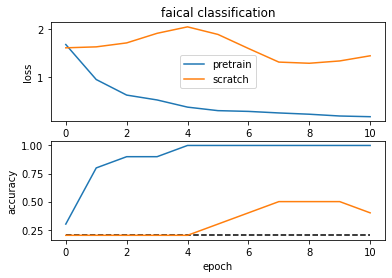

In [28]:
# Comparision
plt.figure()
plt.subplot(211)
plt.plot(lossfunc,label='pretrain')
plt.plot(lossfunc2,label='scratch')
plt.ylabel('loss')
plt.legend()
plt.title('faical classification')
plt.subplot(212)
plt.plot([0,epochs],torch.ones(2)/nppl,'k--')
plt.plot(accfunc,label='pretrain')
plt.plot(accfunc2,label='scratch')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [29]:
# Verify with original images

resnet.classify = True
logit = resnet2(images_tensor.to(device))

print('Prediction from the trained network (chance level = '+str(100/nppl)+'%)')
val, ind = torch.max(logit,1)
prob = sigmoid(val.detach().numpy())*100
for j in range(50):
    print(str(j+1) + ' ' + who[ind[j]] + ' (' + str(prob[j]) + '%)')

Prediction from the trained network (chance level = 20.0%)
1 coey (96.26218%)
2 coey (90.84544%)
3 coey (94.42426%)
4 vicky (77.66703%)
5 coey (77.34347%)
6 coey (99.11221%)
7 coey (98.21373%)
8 coey (63.639557%)
9 vicky (79.76838%)
10 coey (87.82165%)
11 kami (94.12964%)
12 kami (94.04203%)
13 kami (93.37569%)
14 kami (91.173256%)
15 kami (97.09987%)
16 kami (98.754845%)
17 kami (83.47818%)
18 kami (74.21252%)
19 kami (93.96121%)
20 coey (89.82185%)
21 manyi (71.22921%)
22 karen (89.33813%)
23 karen (91.95252%)
24 karen (95.270454%)
25 karen (95.8819%)
26 karen (79.1834%)
27 karen (83.76458%)
28 karen (88.54652%)
29 manyi (77.65068%)
30 karen (93.54289%)
31 manyi (97.85338%)
32 manyi (90.61405%)
33 manyi (83.90147%)
34 manyi (85.33182%)
35 manyi (85.73609%)
36 kami (84.20214%)
37 manyi (83.492035%)
38 manyi (84.645966%)
39 vicky (79.97718%)
40 manyi (83.18341%)
41 vicky (86.87431%)
42 vicky (97.3203%)
43 vicky (97.75343%)
44 vicky (86.22939%)
45 vicky (87.9072%)
46 manyi (77.22756%)
4